In [2]:
import os
import pickle
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from txgnn import TxData
from goatools.obo_parser import GODag
from goatools.godag.go_tasks import get_go2parents, get_go2children
import torch

/home/tysinger/.conda/envs/txgnn_env2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
emb_path = '/om/user/tysinger/models/node_emb.pkl'
with open(emb_path, 'rb') as f:
    embeddings = pickle.load(f)

In [5]:
prot_embs = embeddings['gene/protein']
drug_embs = embeddings['drug']

In [6]:
# Compute t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
prot_tsne_results = tsne.fit_transform(prot_embs)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
drug_tsne_results = tsne.fit_transform(drug_embs)

In [145]:
def plot(cluster_list, tsne_results, title= 'Protein Embeddings'):
    df = pd.DataFrame()
    df['t-SNE 1'] = tsne_results[:,0]
    df['t-SNE 2'] = tsne_results[:,1]
    df['cluster'] = cluster_list

    colors = sns.color_palette("tab10")
    palette = {cluster: 'lightgrey' if cluster == 'Other' else colors.pop() for cluster in set(cluster_list)}

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="t-SNE 1", y="t-SNE 2",
        hue='cluster',
        palette=palette,
        data=df[df['cluster'] == 'Other'],
        legend=False,  
        alpha=0.5
    )

    sns.scatterplot(
        x="t-SNE 1", y="t-SNE 2",
        hue='cluster',
        palette=palette,
        data=df[df['cluster'] != 'Other'],
        legend="full",
        alpha=0.4  
    )
    plt.title(title)
    plt.legend(title='Clusters')
    plt.show()

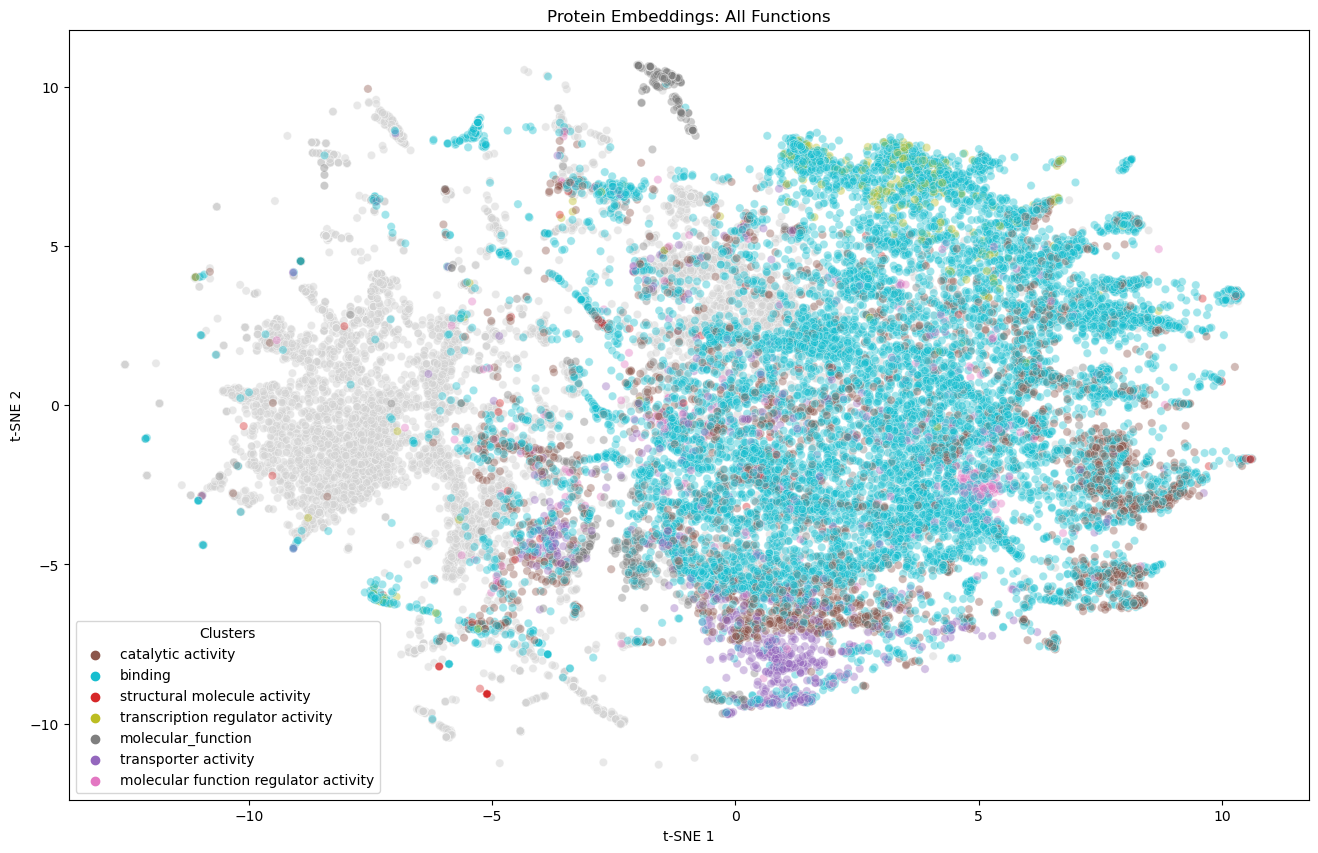

In [146]:
plot(all_prot_functions_names, prot_tsne_results, 'Protein Embeddings: All Functions')

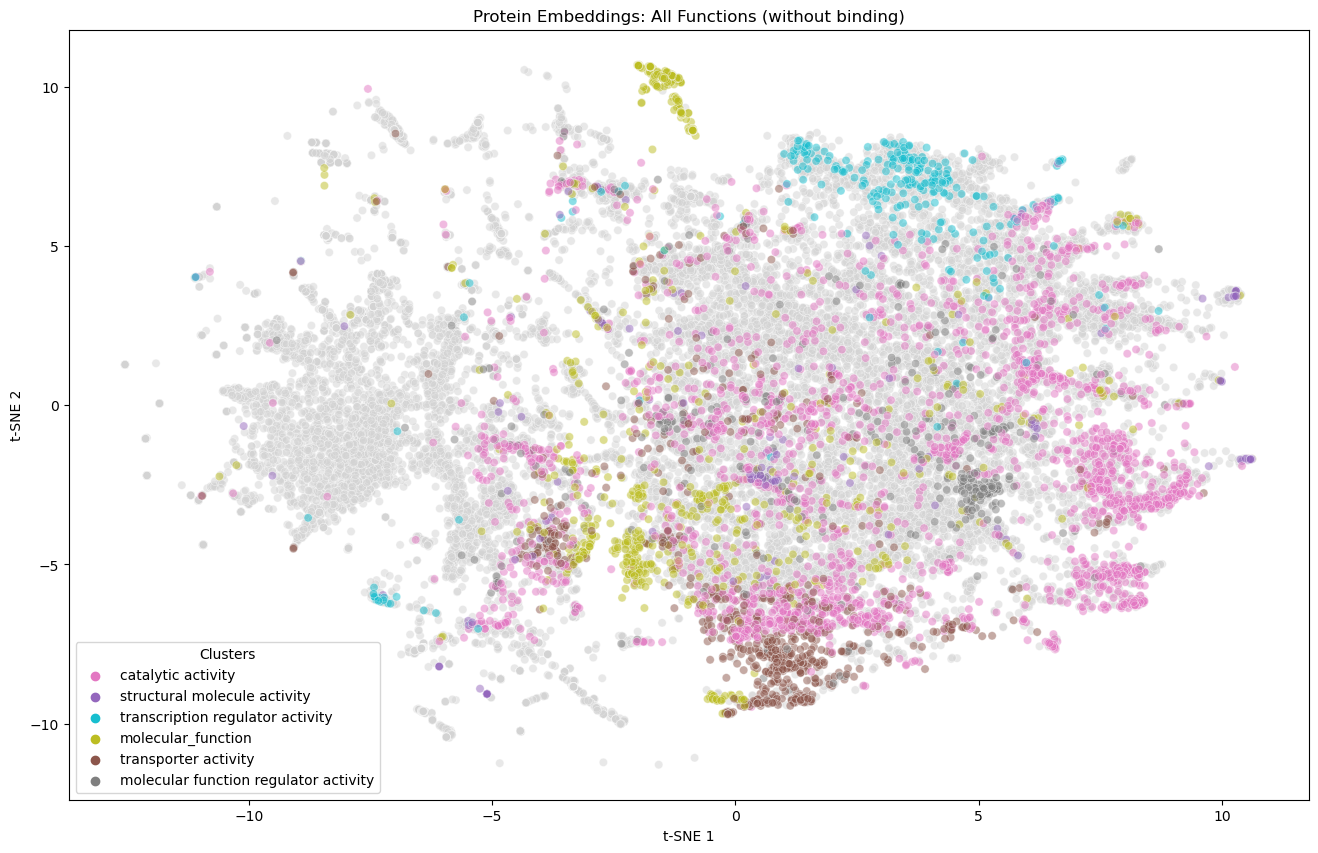

In [144]:
df = pd.DataFrame()
df['t-SNE 1'] = prot_tsne_results[:,0]
df['t-SNE 2'] = prot_tsne_results[:,1]
df['cluster'] = all_prot_functions_names

colors = sns.color_palette("tab10")
palette = {cluster: 'lightgrey' if (cluster == 'Other' or cluster == 'binding') else colors.pop() for cluster in set(all_prot_functions_names)}

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    hue='cluster',
    palette=palette,
    data=df[(df['cluster'] == 'Other')|(df['cluster'] == 'binding')],
    legend=False,  
    alpha=0.5
)
filtered_df = df[(df['cluster'] != 'Other') & (df['cluster'] != 'binding')]
sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    hue='cluster',
    palette=palette,
    data=filtered_df,
    legend="full",
    alpha=0.5  
)
plt.title('Protein Embeddings: All Functions (without binding)')
plt.legend(title='Clusters')
plt.show()

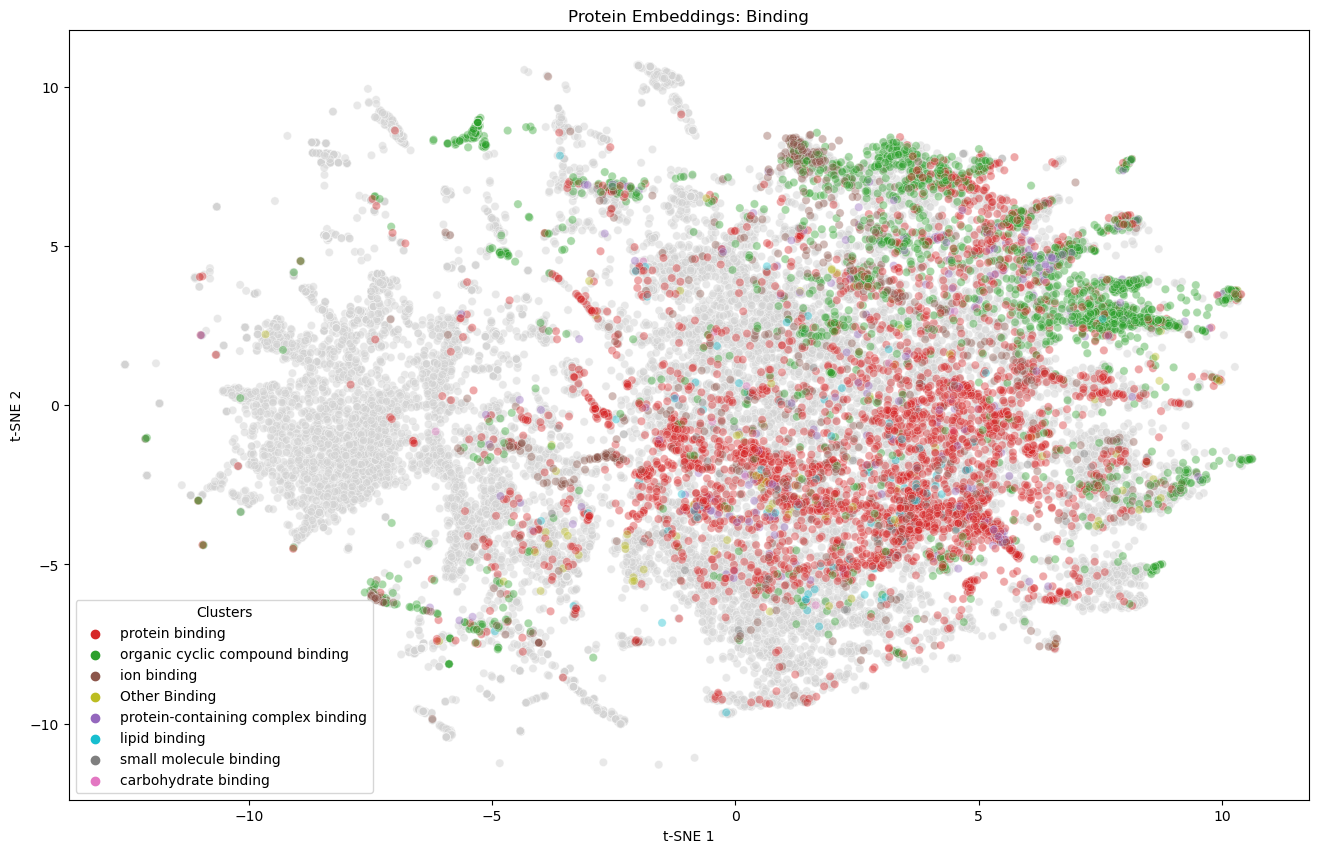

In [147]:
plot(binding_prot_functions_names, prot_tsne_results, 'Protein Embeddings: Binding')

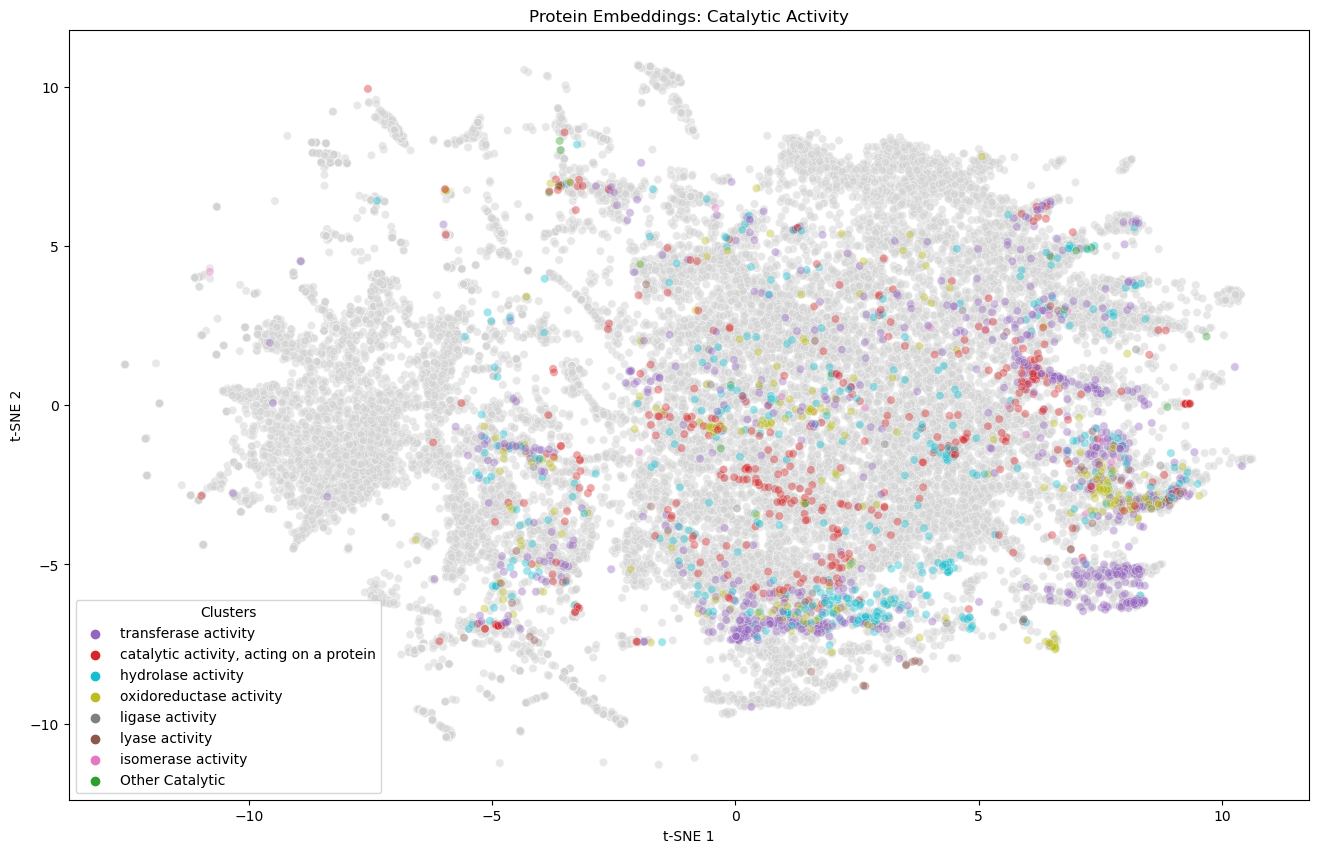

In [148]:
plot(catalytic_prot_functions_names, prot_tsne_results, 'Protein Embeddings: Catalytic Activity')

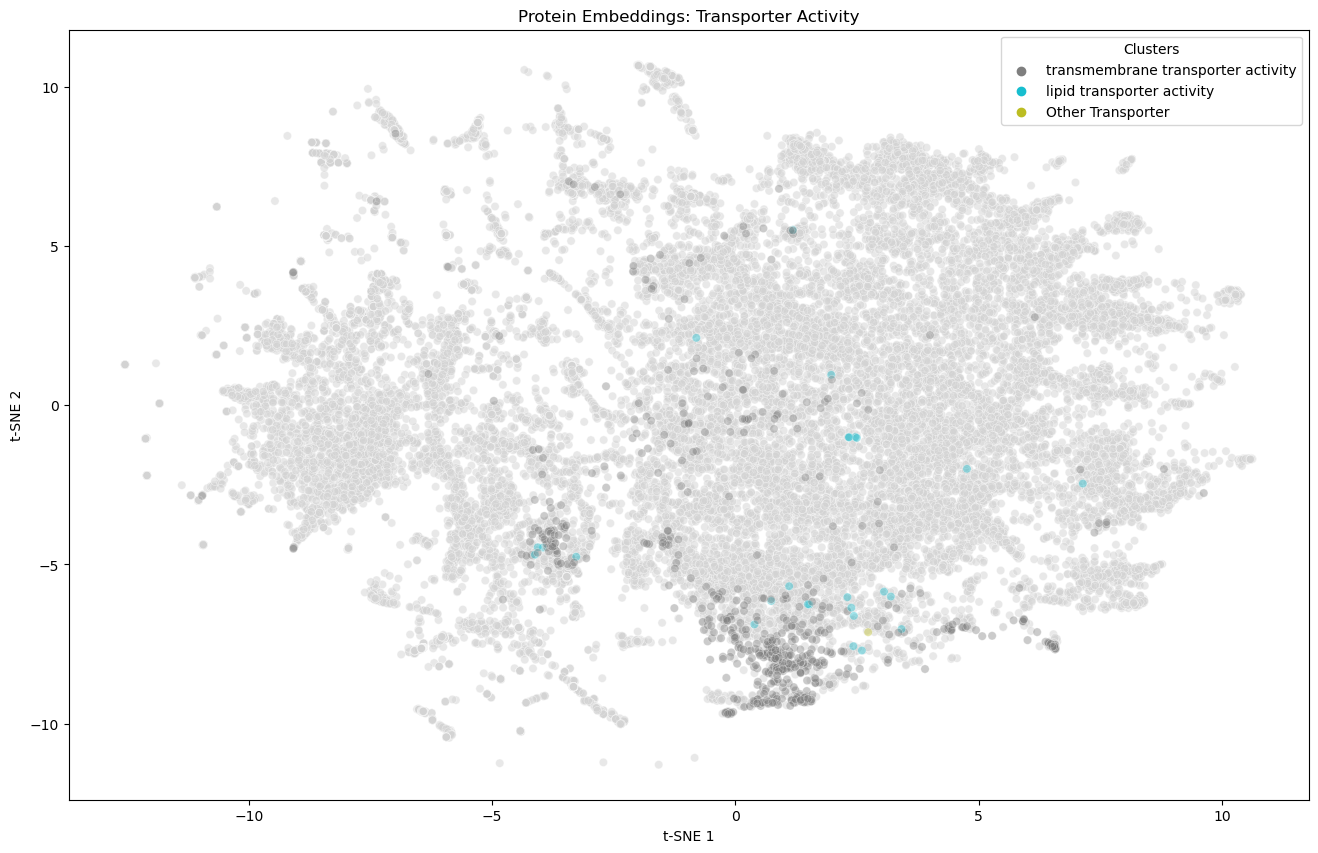

In [149]:
plot(transporter_prot_functions_names, prot_tsne_results, 'Protein Embeddings: Transporter Activity')

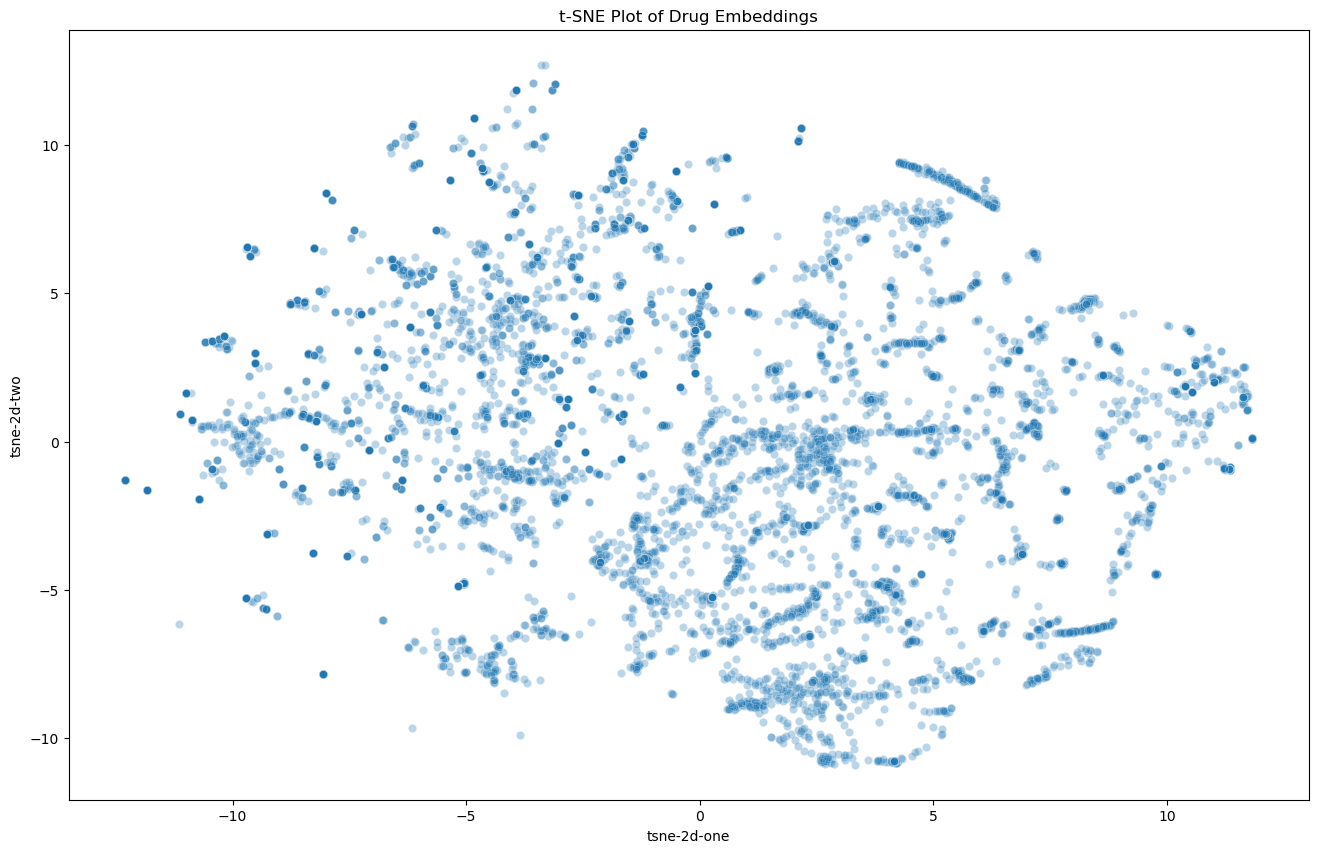

In [20]:
df = pd.DataFrame()
df['tsne-2d-one'] = drug_tsne_results[:,0]
df['tsne-2d-two'] = drug_tsne_results[:,1]

# Plot using Seaborn
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hsv", 10),
    data=df,
    legend="full",
    alpha=0.3
)
plt.title('t-SNE Plot of Drug Embeddings')
plt.show()

### Get molecular function for each protein

In [43]:
def get_ordered_goids():
    TxData_inst = TxData(data_folder_path = '/om/user/tysinger/kg/')
    TxData_inst.prepare_split(split = 'random', seed = 42, no_kg = False)
    x_df = TxData_inst.df[TxData_inst.df.x_type == 'molecular_function'][['x_idx','x_id']]
    y_df = TxData_inst.df[TxData_inst.df.y_type == 'molecular_function'][['y_idx','y_id']]
    x_zipped = set(zip(x_df['x_idx'], x_df['x_id']))
    y_zipped = set(zip(y_df['y_idx'], y_df['y_id']))
    all_nodes = x_zipped.union(y_zipped)
    idx2id = dict(all_nodes)
    nodes = pd.read_csv('/om/user/tysinger/kg/nodes.csv')
    nodes_mf = nodes[nodes.node_type == 'molecular_function']
    id2name = dict(zip(nodes_mf['node_id'], nodes_mf['node_name']))
    ordered_names = []
    ordered_ids = []
    for node in TxData_inst.G.nodes('molecular_function').tolist():
        id = idx2id[node]
        ordered_ids.append(str(int(float(id))))
        name = id2name[str(int(float(id)))]
        ordered_names.append(name)
    def get_go_id(id):
        while len(id) != 7:
            id = '0' + id
        return 'GO:' + id
    ordered_goids = [get_go_id(id) for id in ordered_ids]
    return ordered_goids

In [44]:
dirname = '/om/user/tysinger/TxGNN/txgnn/data_splits/'
obo_path = os.path.join(dirname, 'go-basic.obo')
go_dag = GODag(obo_path)

/om/user/tysinger/TxGNN/txgnn/data_splits/go-basic.obo: fmt(1.2) rel(2023-10-09) 46,296 Terms


In [45]:
ordered_goids = get_ordered_goids()

Found local copy...
Found local copy...
Found local copy...
Found saved processed KG... Loading...
Splits detected... Loading splits....
Creating DGL graph....
Done!


In [11]:
dirname = '/om/user/tysinger/TxGNN/txgnn/data_splits/'
obo_path = os.path.join(dirname, 'go-basic.obo')
go_dag = GODag(obo_path)

/om/user/tysinger/TxGNN/txgnn/data_splits/go-basic.obo: fmt(1.2) rel(2023-10-09) 46,296 Terms


In [47]:
all_go_cluster_list = ['GO:0005488', 'GO:0005198', 'GO:0003824', 'GO:0038024', 'GO:0016209',
                   'GO:0140104', 'GO:0005215', 'GO:0045182', 'GO:0140110',
                   'GO:0098772', 'GO:0003674']
all_goid2name = {goid:go_dag[goid].name for goid in all_go_cluster_list}
all_goid2children = {goid:go_dag[goid].get_all_children() for goid in all_go_cluster_list}

In [48]:
all_goid2name

{'GO:0005488': 'binding',
 'GO:0005198': 'structural molecule activity',
 'GO:0003824': 'catalytic activity',
 'GO:0038024': 'cargo receptor activity',
 'GO:0016209': 'antioxidant activity',
 'GO:0140104': 'molecular carrier activity',
 'GO:0005215': 'transporter activity',
 'GO:0045182': 'translation regulator activity',
 'GO:0140110': 'transcription regulator activity',
 'GO:0098772': 'molecular function regulator activity',
 'GO:0003674': 'molecular_function'}

In [60]:
binding_go_cluster_list = [child.item_id for child in list(go_dag['GO:0005488'].children)]
binding_goid2name = {goid:go_dag[goid].name for goid in binding_go_cluster_list}
binding_goid2children = {goid:go_dag[goid].get_all_children() for goid in binding_go_cluster_list}

In [91]:
catalytic_go_cluster_list = [child.item_id for child in list(go_dag['GO:0003824'].children)]
catalytic_goid2name = {goid:go_dag[goid].name for goid in catalytic_go_cluster_list}
catalytic_goid2children = {goid:go_dag[goid].get_all_children() for goid in catalytic_go_cluster_list}

In [141]:
transporter_go_cluster_list = [child.item_id for child in list(go_dag['GO:0005215'].children)]
transporter_goid2name = {goid:go_dag[goid].name for goid in transporter_go_cluster_list}
transporter_goid2children = {goid:go_dag[goid].get_all_children() for goid in transporter_go_cluster_list}

In [114]:
from collections import Counter
def parent_go_list(ordered_goids, goid2children, agg = True, type = '', threshold = 50):
    parent_go = []
    for id in ordered_goids:
        parent = 'Other'
        for go_parent in goid2children:
            if id in goid2children[go_parent]:
                parent = go_parent
                break
        parent_go.append(parent)
    count = Counter(parent_go)
    print(count)
    if agg:
        low_freq_ids = {go_id for go_id, cnt in count.items() if cnt <= threshold}
        parent_go = ['Other' + type if go_id in low_freq_ids else go_id for go_id in parent_go]
    return parent_go

def get_clusters(parent_go, goid2name):
    all_prot_functions = []
    for idx, prot_idx in enumerate(TxData_inst.G.nodes('gene/protein').tolist()):
        nodes = TxData_inst.G.successors(prot_idx, etype='molfunc_protein')
        num_nodes = len(TxData_inst.G.nodes('molecular_function'))
        node_profile = torch.zeros((num_nodes,))
        node_profile[nodes] = 1.
        profile = node_profile.tolist()
        filtered_strings = [parent_go[i] for i in range(len(profile)) if profile[i] == 1]
        unique_counts = Counter(filtered_strings)
        if len(unique_counts) == 0:
            key_max = 'Other'
        else:
            key_max = max(unique_counts, key=unique_counts.get)
        all_prot_functions.append(key_max)
    all_prot_functions_names = [goid2name[goid] if goid[:5] != 'Other' else goid for goid in all_prot_functions]
    return all_prot_functions, all_prot_functions_names

In [118]:
all_parent_go = parent_go_list(ordered_goids, all_goid2children, threshold=20)
all_prot_functions, all_prot_functions_names = get_clusters(all_parent_go, all_goid2name)

Counter({'GO:0003824': 7381, 'GO:0005488': 1816, 'GO:0005215': 989, 'GO:0003674': 428, 'Other': 273, 'GO:0098772': 183, 'GO:0005198': 42, 'GO:0140110': 22, 'GO:0038024': 17, 'GO:0140104': 15, 'GO:0045182': 3})


In [116]:
binding_parent_go = parent_go_list(ordered_goids, binding_goid2children, type=' Binding', threshold = 30)
binding_prot_functions, binding_prot_functions_names = get_clusters(binding_parent_go, binding_goid2name)

Counter({'Other': 9396, 'GO:0005515': 888, 'GO:0097159': 477, 'GO:0044877': 110, 'GO:0036094': 69, 'GO:0043167': 67, 'GO:0030246': 36, 'GO:0008289': 35, 'GO:0033218': 27, 'GO:0042562': 21, 'GO:0097367': 21, 'GO:0051540': 5, 'GO:0050840': 5, 'GO:0048038': 3, 'GO:0051192': 2, 'GO:0019215': 1, 'GO:0070026': 1, 'GO:0046812': 1, 'GO:0031409': 1, 'GO:0005549': 1, 'GO:0070025': 1, 'GO:0043176': 1})


In [115]:
catalytic_parent_go = parent_go_list(ordered_goids, catalytic_goid2children, type=' Catalytic')
catalytic_prot_functions, catalytic_prot_functions_names = get_clusters(catalytic_parent_go, catalytic_goid2name)

Counter({'Other': 3800, 'GO:0016740': 2416, 'GO:0016491': 2296, 'GO:0016787': 1271, 'GO:0016829': 599, 'GO:0016874': 255, 'GO:0016853': 252, 'GO:0140096': 200, 'GO:0140640': 39, 'GO:0009975': 25, 'GO:0032451': 11, 'GO:0061783': 5})


In [142]:
transporter_parent_go = parent_go_list(ordered_goids, transporter_goid2children, type=' Transporter', threshold = 30)
transporter_prot_functions, transporter_prot_functions_names = get_clusters(transporter_parent_go, transporter_goid2name)

Counter({'Other': 10140, 'GO:0022857': 981, 'GO:0005319': 46, 'GO:0140318': 2})
